# Calculation of dipole orientations $\theta_{\mu}$

This code uses atomic coordinates from DFT simulations run at the B3LYP/aug-cc-pVDZ level to calculate "dipole orientations" $\theta_{\mu}$ for each of the systems in our study.

### Required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pprint as pp
from matplotlib import rc
import os
import json

## Helper functions

### Finding the best-fit plane for the atoms making up the backbone of the solvent molecule

In [2]:
def SVD(X):
    """
    Singular value decomposition method used to find best-fit plane of backbone atoms in the solvent molecules of our system.
    Source: https://gist.github.com/lambdalisue/7201028
    
    Parameters
    -----------
    X : numpy.array
        Array of shape (n, 3) where n is the number of backbone atoms.
        
    Returns
    -------
    a, b, c, d : float
        Coefficients of the plane equation ax + by + cz + d = 0.
    
    """
    # Find the average of points (centroid) along the columns
    C = np.average(X, axis=0)

    # Create CX vector (centroid to point) matrix
    CX = X - C
    # Singular value decomposition
    U, S, V = np.linalg.svd(CX)
    # The last row of V matrix indicate the eigenvectors of
    # smallest eigenvalues (singular values).
    N = V[-1]

    # Extract a, b, c, d coefficients.
    x0, y0, z0 = C
    a, b, c = N
    d = -(a * x0 + b * y0 + c * z0)

    return [a, b, c, d]

### Vector operations

In [3]:
def get_magnitude(vector):
    """
    Calculates the magnitude (length) of a vector.
    
    Parameters
    ----------
    vector : numpy.array
        Array of shape (3,).
    
    Returns
    -------
    float
        Magnitude of the vector.
        
    """
    
    return np.sqrt(np.dot(vector, vector))

def normalize(vector):
    """
    Normalizes a vector (i.e., scales it so that its magnitude is 1).
    If the magnitude of the vector is 0, raises an exception, since the zero vector cannot be normalized.
    
    Parameters
    ----------
    vector : numpy.array
        Array of shape (3,).
        
    Returns
    -------
    numpy.array
        Normalized vector.
    
    """
    if get_magnitude(vector) == 0:
        raise Exception("Length of vector is 0.")
    else:
        return vector / get_magnitude(vector)

def project_vector_onto_vector(v1, v2):
    """
    Projects vector v1 onto vector v2.
    
    Parameters
    ----------
    v1 : numpy.array
        Array of shape (3,).
    v2 : numpy.array
        Array of shape (3,).
        
    Returns
    -------
    numpy.array
        The projection of v1 onto v2.
    
    """
    return np.dot(v1, v2) / np.dot(v2, v2) * v2

def project_vector_onto_plane(vector, plane_normal):
    """
    Find the component of a vector that is parallel to a plane.
    The plane is defined by its normal vector, which, when the plane is written in the form ax + by + cz + d = 0, is the vector [a, b, c].
    
    Parameters
    ----------
    vector : numpy.array
        Array of shape (3,).
    plane_normal : numpy.array
        Array of shape (3,).
        
    Returns
    -------
    numpy.array
        The component of a vector that is parallel to a plane.
    
    """
    return vector - project_vector_onto_vector(vector, plane_normal)

def get_angle_between_vectors(v1, v2):
    """
    Find the angle between the two vectors, in degrees, between -180 and 180.
    
    Parameters
    ----------
    v1 : numpy.array
        Array of shape (3,).
    v2 : numpy.array
        Array of shape (3,).
        
    Returns
    -------
    float
        The angle between the two vectors
    
    """
    return np.degrees(np.arctan2(np.linalg.norm(np.cross(v1, v2)), np.dot(v1, v2)))

def get_acute_angle_between_vectors(a):
    """
    Given a result from angle_between_vectors, returns the acute angle ([0, 90] degrees) between the two lines that represent the span of each vector individually.
    
    Parameters
    ----------
    a : float
        The result from angle_between_vectors, which is an angle, in degrees, between -180 and 180.
        
    Returns
    -------
    float
        The acute angle
        
    """
    
    return min(abs(a), 180 - abs(a))

### Working with atomic coordinates

In [4]:
masses = {
    "H": 1.00784,
    "He": 4.0026,
    "Li": 6.94,
    "Be": 9.0122,
    "B": 10.81,
    "C": 12.011,
    "N": 14.007,
    "O": 15.999,
    "F": 18.998,
}

def get_center_of_mass(atom_coordinates):
    """
    Using atom_coordinates and masses, determines the center of mass of the system.
    
    Parameters
    ----------
    atom_coordinates : list
        List of shape (n, 2) where n is the number of atoms in the system.
        The first element of each row is a string representing the atom type (e.g., "H", "C", etc.).
        The second element of each row is a list of shape (3,) representing the x, y, and z coordinates of the atom.
        
    Returns
    -------
    numpy.array
        Array of shape (3,) representing the center of mass of the system.
    
    """
    
    center_of_mass = np.array([0.0, 0.0, 0.0])
    total_mass = 0.0

    for atom in atom_coordinates:
        center_of_mass += np.array(atom[1]) * masses[atom[0]]
        total_mass += masses[atom[0]]

    center_of_mass /= total_mass

    return center_of_mass

def get_atom_coordinates(atom_coordinates, atom_types):
    """
    Returns the coordinates of certain atoms from atom_coordinates.
    
    Parameters
    ----------
    atom_coordinates : list
        List of shape (n, 2) where n is the number of atoms in the system.
        The first element of each row is a string representing the atom type (e.g., "H", "C", etc.).
        The second element of each row is a list of shape (3,) representing the x, y, and z coordinates of the atom.
    atom_types : list
        List of strings representing the atom types to extract.
        Example: ["C", "O"] for carbon and oxygen atoms, which represent the backbone of the solvent molecule.
        
    Returns
    -------
    numpy.array
        Array of shape (m, 3) where m is the number of atoms of the specified type.
        If no atoms of the specified type are found, raises an exception.
    
    """
    coordinates = []
    
    for atom in atom_coordinates:
        if atom[0] in atom_types:
            coordinates.append(atom[1])

    if len(coordinates) == 0:
        raise Exception("No atoms of the specified type were found.")
    
    return np.array(coordinates)

def get_projected_oxygen_vector(atom_coordinates, a, b, c):
    """
    Returns a vector connecting the oxygen atoms in the solvent molecule, projected onto the plane defined by the best-fit plane of the backbone atoms.
    The direction of the vector does not matter.
    All of the solvent molecules in our system have two oxygen atoms.
    
    Parameters
    ----------
    atom_coordinates : list
        List of shape (n, 2) where n is the number of atoms in the system.
        The first element of each row is a string representing the atom type (e.g., "H", "C", etc.).
        The second element of each row is a list of shape (3,) representing the x, y, and z coordinates of the atom.
        
    Returns
    -------
    numpy.array
        Array of shape (3,) representing the projected oxygen vector.
    
    """
    oxygen_coordinates = get_atom_coordinates(atom_coordinates, ["O"])
    oxygen_vector = oxygen_coordinates[1] - oxygen_coordinates[0]
    projected_oxygen_vector = project_vector_onto_plane(oxygen_vector, np.array([a, b, c]))
    
    return projected_oxygen_vector

def get_normal_to_oxygen_in_plane(projected_oxygen_vector, a, b, c):
    """
    Finds the normal vector to the vector connecting the oxygen atoms in the solvent molecule, in the plane defined by the best-fit plane of the backbone atoms.
    
    Parameters
    ----------
    projected_oxygen_vector : numpy.array
        Array of shape (3,) representing the projected oxygen vector.
    a, b, c : float
        Coefficients of the plane equation ax + by + cz + d = 0 reprsenting the normal vector of the best-fit plane of the backbone atoms.
        
    Returns
    -------
    numpy.array
        Array of shape (3,) representing the normal vector to the vector connecting the oxygen atoms in the solvent molecule.
    
    """
    return np.cross(projected_oxygen_vector, normalize(np.array([a, b, c])))

def get_projected_dipole(dipole, a, b, c):
    """
    Projects dipole from Gaussian output onto the plane defined by the best-fit plane of the backbone atoms.
    
    Parameters
    ----------
    dipole : numpy.array
        Array of shape (3,) representing the dipole vector, which is from Gaussian output. It is not read in from the input file in this repository.
    a, b, c : float
        Coefficients of the plane equation ax + by + cz + d = 0 reprsenting the normal vector of the best-fit plane of the backbone atoms.
        
    Returns
    -------
    numpy.array
        Array of shape (3,) representing the projected dipole vector.    
    
    """
    return project_vector_onto_plane(dipole, np.array([a, b, c]))

## Computing the dipole orientations

In [5]:
# The "systems" nested dictionary is initialized with the dipoles of each system, taken from Gaussian.
# In Gaussian, the dipole points from negative to positive, but in chemistry, the usual convention in chemistry is to point from positive to negative.
# So, we have negated every component of the dipole to match the chemistry convention in this script.
# The rest of this nested dictionary will be filled in with the results of the calculations, which we can visualize with interactive plots at the end.

systems = {
    "EME_Li": {
        "dipole": np.array([-0.9599, 2.3548, 0.2477]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "MPE_Li": {
        "dipole": np.array([-2.9607, 2.2494, 0.1991]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "DEE_Li": {
        "dipole": np.array([0.0004, -1.5195, 0.0007]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "F1EME_Li": {
        "dipole": np.array([-0.054, -0.0468, -0.1773]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "F2EME_Li": {
        "dipole": np.array([3.7026, 0.3234, -0.8998]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "F3EME_Li": {
        "dipole": np.array([-5.4374, -0.4811, 0.6132]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "F3DEE_Li": {
        "dipole": np.array([-4.2566, -1.8344, 0.6705]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "F4DEE_Li": {
        "dipole": np.array([-0.0002, -3.9096, 0.0005]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
    "F5DEE_Li": {
        "dipole": np.array([-1.778, -5.5518, 1.4526]),
        "atom_coordinates": [],
        "center_of_mass": None,
        "abcd": None,
        "projected_oxygen_vector": None,
        "normal_to_oxygen_in_plane": None,
        "projected_dipole": None,
        "acute_angle": None,
    },
}

for filename in os.listdir("./optimized-structures"):
    system = filename.split(".")[0]
    
    # read in data from the file
    atom_coordinates = systems[system]["atom_coordinates"]
    with open(f"./optimized-structures/{filename}", "r") as f:
        for line in f:
            atom_coordinates.append([line.split()[0], [float(i) for i in line.split()[1:]]])
    
    # determine the center of mass of the system
    systems[system]["center_of_mass"] = get_center_of_mass(atom_coordinates)
    
    backbone_coordinates = get_atom_coordinates(atom_coordinates, ["C", "O"])
    
    # find the best fit plane for the backbone coordinates
    systems[system]["abcd"] = SVD(backbone_coordinates)
    a, b, c, d = systems[system]["abcd"]
    
    # get oxygen vector and normal to oxygen vector in plane
    projected_oxygen_vector = get_projected_oxygen_vector(atom_coordinates, a, b, c)
    normal_to_oxygen_in_plane = get_normal_to_oxygen_in_plane(projected_oxygen_vector, a, b, c)
    systems[system]["projected_oxygen_vector"] = projected_oxygen_vector
    systems[system]["normal_to_oxygen_in_plane"] = normal_to_oxygen_in_plane
    
    # get projected dipole
    dipole = systems[system]["dipole"]
    projected_dipole = get_projected_dipole(dipole, a, b, c)
    systems[system]["projected_dipole"] = get_projected_dipole(dipole, a, b, c)
    
    # get angle between dipole and normal to oxygen vector in plane
    angle = get_angle_between_vectors(projected_dipole, normal_to_oxygen_in_plane)
    systems[system]["acute_angle"] = get_acute_angle_between_vectors(angle)

## Saving the results

In [6]:
# Custom JSON Encoder to handle numpy arrays, which are not JSON serializable
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert NumPy array to list
        return super(NumpyEncoder, self).default(obj)

# Serialize and write to a JSON file
with open('summary.json', 'w') as f:
    json.dump(systems, f, cls=NumpyEncoder, indent=4)

## Visualizing the dipole orientations

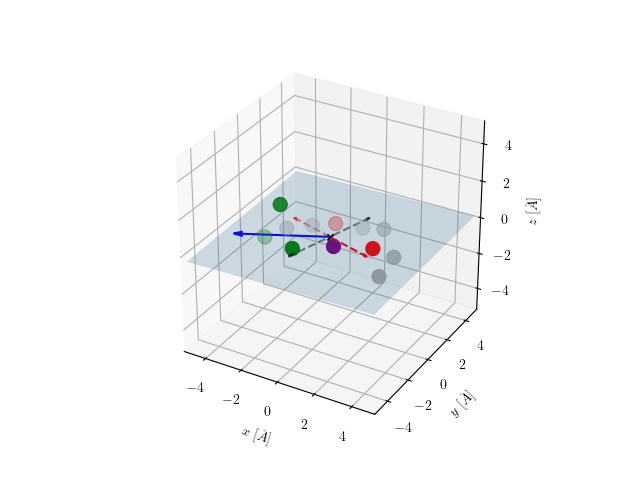

In [7]:
# Select the system you want to visualize
# ---------------------------------------
system = "F3DEE_Li"

# Select whichever atoms you want to plot from the system
# -------------------------------------------------------
atom_coordinates = systems[system]["atom_coordinates"]

carbon_coordinates = get_atom_coordinates(atom_coordinates, ["C"])
oxygen_coordinates = get_atom_coordinates(atom_coordinates, ["O"])
lithium_coordinates = get_atom_coordinates(atom_coordinates, ["Li"])

if any(atom[0] == "F" for atom in atom_coordinates):
    fluorine_coordinates = get_atom_coordinates(atom_coordinates, ["F"])

# Set up plot
# -----------
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel(r'$x$ $[\AA]$')
ax.set_ylabel(r'$y$ $[\AA]$')
ax.set_zlabel(r'$z$ $[\AA]$')

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

ax.set_box_aspect([1,1,1])

# Plot the best-fit plane
# -----------------------
a, b, c, d = systems[system]["abcd"]

x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
x, y = np.meshgrid(x, y)
z = -(a * x + b * y + d) / c

ax.plot_surface(x, y, z, alpha=0.2)

# Plot whichever atoms you want from the system
# ---------------------------------------------
ax.scatter(carbon_coordinates[:,0], carbon_coordinates[:,1], carbon_coordinates[:,2], c='darkgray', marker='o', s=100)
ax.scatter(oxygen_coordinates[:,0], oxygen_coordinates[:,1], oxygen_coordinates[:,2], c='red', marker='o', s=100)
ax.scatter(lithium_coordinates[:,0], lithium_coordinates[:,1], lithium_coordinates[:,2], c='purple', marker='o', s=100)
if any(atom[0] == "F" for atom in atom_coordinates):
    ax.scatter(fluorine_coordinates[:,0], fluorine_coordinates[:,1], fluorine_coordinates[:,2], c='green', marker='o', s=100)
    
# Mark the center of mass of the system
# -------------------------------------
ax.scatter(*systems[system]["center_of_mass"], c='k', marker='x')

# Plot the dipole and vectors    
# ---------------------------
ax.quiver(*systems[system]["center_of_mass"], *systems[system]["projected_oxygen_vector"], color='red', arrow_length_ratio=0.1, linestyle='dashed')
ax.quiver(*systems[system]["center_of_mass"], *(-1*systems[system]["projected_oxygen_vector"]), color='red', arrow_length_ratio=0.1, linestyle='dashed', alpha=0.5)

ax.quiver(*systems[system]["center_of_mass"], *systems[system]["normal_to_oxygen_in_plane"], color='black', arrow_length_ratio=0.1, linestyle='dashed', alpha=0.5)
ax.quiver(*systems[system]["center_of_mass"], *(-1*systems[system]["normal_to_oxygen_in_plane"]), color='black', arrow_length_ratio=0.1, linestyle='dashed', alpha=0.5)

ax.quiver(*systems[system]["center_of_mass"], *systems[system]["projected_dipole"], color='blue', arrow_length_ratio=0.1)

# Show the plot
# -------------
plt.show()


## Unit tests

In [8]:
import ipytest # type: ignore
ipytest.autoconfig()

In [9]:
%%ipytest

import pytest

# testing get_magnitude
@pytest.mark.parametrize("vector, expected", [
    (np.array([1, 0, 0]), 1),
    (np.array([1, 1, 0]), np.sqrt(2)),
    (np.array([1, 1, 1]), np.sqrt(3)),
    (np.array([1, 2, 3]), np.sqrt(14)),
])
def test_get_magnitude(vector, expected):
    result = get_magnitude(vector)
    assert np.allclose(result, expected)

# testing normalize
@pytest.mark.parametrize("vector, expected", [
    (np.array([1, 0, 0]), np.array([1, 0, 0])),
    (np.array([1, 1, 0]), np.array([1/np.sqrt(2), 1/np.sqrt(2), 0])),
    (np.array([1, 1, 1]), np.array([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)])),
    (np.array([1, 2, 3]), np.array([1/np.sqrt(14), 2/np.sqrt(14), 3/np.sqrt(14)])),
])
def test_normalize(vector, expected):
    result = normalize(vector)
    assert np.allclose(result, expected)

#testing get_angle_between_vectors    
@pytest.mark.parametrize("v1, v2, expected", [
    (np.array([-50, -50, -50]), np.array([50, 50, 0]), 144.736),
    (np.array([0, 0, 0]), np.array([0, 0, 0]), 0),
    (np.array([1, 0, 0]), np.array([0, 1, 0]), 90),
    (np.array([1, 1, 0]), np.array([0, 1, 0]), 45),
    (np.array([5, 1, 1]), np.array([0, 1, 0]), 78.9042),
    (np.array([1, 2, 3]), np.array([1, 2, 3]), 0),
    (np.array([2, 3, 4]), np.array([1, 1, 1]), 15.2252),
])
def test_get_angle_between_vectors(v1, v2, expected):
    result = get_angle_between_vectors(v1, v2)
    assert np.allclose(result, expected)

# testing get_acute_angle_between_vectors   
@pytest.mark.parametrize("a, expected", [
    (0, 0),
    (45, 45),
    (90, 90),
    (135, 45),
    (180, 0),
    (-45, 45),
    (-90, 90),
    (-135, 45),
    (-180, 0),
    (179.999, 0.001),
])    
def test_get_acute_angle_between_vectors(a, expected):
    result = get_acute_angle_between_vectors(a)
    assert np.allclose(result, expected)

# testing project_vector_onto_vector    
@pytest.mark.parametrize("v1, v2, expected", [
    (np.array([1, 2]), np.array([2, 3]), np.array([16/13, 24/13])),
    (np.array([1, 2, 1]), np.array([2, 3, 1]), np.array([9/7, 27/14, 9/14])),
    (np.array([1, 0, 0]), np.array([0, 0, 1]), np.array([0, 0, 0])),
    (np.array([1, 0, 0]), np.array([-1, 0, 0]), np.array([1, 0, 0])),
    (np.array([1, 0, 0]), np.array([-1, 1, 0]), np.array([1/2, -1/2, 0])),
])
def test_project_vector_onto_vector(v1, v2, expected):
    result = project_vector_onto_vector(v1, v2)
    assert np.allclose(result, expected)

# testing project_vector_onto_plane
@pytest.mark.parametrize("vector, plane_normal, expected", [
    (np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([1, 0, 0])), 
    (np.array([1, 1, 0]), np.array([0, 1, 0]), np.array([1, 0, 0])),
    (np.array([1, 1, 1]), np.array([0, 1, 0]), np.array([1, 0, 1])),
    (np.array([1, 2, 3]), np.array([1, 2, 3]), np.array([0, 0, 0])),
    (np.array([2, 3, 4]), np.array([1, 1, 1]), np.array([-1, 0, 1])),
    (np.array([2, 3, 5]), np.array([1, 1, 1]), np.array([-4/3, -1/3, 5/3])),
    (np.array([1, 4, 2]), np.array([2, -1, 3]), np.array([3/7, 30/7, 8/7])),
    (np.array([-1, 2, 3]), np.array([3, 1, -2]), np.array([1/2, 5/2, 2])),
])
def test_project_vector_onto_plane(vector, plane_normal, expected):
    result = project_vector_onto_plane(vector, plane_normal)
    assert np.allclose(result, expected)


......................................                                                       [100%]
38 passed in 0.25s
